## IMPORT LIBRARES AND PACKAGES

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2

from PIL import Image
from scipy import stats

from keras.utils import to_categorical

## [1] DATA PREPARATION

Setup data directory

In [2]:
IMAGE_DIRECTORY = "./data-1/cohn-kanade-images/"
DATA_LABEL_DIRECTORY = "./data-1/data_labels.csv"

#### Load Label Dataset

In [3]:
df = pd.read_csv(DATA_LABEL_DIRECTORY)

Explore head

In [4]:
df.head(5)

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,...,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
0,S005,1,11,./cohn-kanade-images/S005/001/S005_001_0000001...,S005_001_00000011,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,S010,1,14,./cohn-kanade-images/S010/001/S010_001_0000001...,S010_001_00000014,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,negative
2,S010,2,14,./cohn-kanade-images/S010/002/S010_002_0000001...,S010_002_00000014,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,surprise
3,S010,3,18,./cohn-kanade-images/S010/003/S010_003_0000001...,S010_003_00000018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,S010,4,19,./cohn-kanade-images/S010/004/S010_004_0000001...,S010_004_00000019,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,negative


Explore Tail

In [5]:
df.tail(5)

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,...,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
555,S506,4,38,./cohn-kanade-images/S506/004/S506_004_0000003...,S506_004_00000038,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,negative
556,S506,6,42,./cohn-kanade-images/S506/006/S506_006_0000004...,S506_006_00000042,1,1,1,0,0,...,0,0,0,0,0,1,0,0,1,negative
557,S895,2,7,./cohn-kanade-images/S895/002/S895_002_0000000...,S895_002_00000007,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,negative
558,S999,1,18,./cohn-kanade-images/S999/001/S999_001_0000001...,S999_001_00000018,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,negative
559,S999,3,55,./cohn-kanade-images/S999/003/S999_003_0000005...,S999_003_00000055,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,negative


Convert Emotion Label To Numeric

In [6]:
target_mapping = {'negative': 0, 'positive': 1, 'surprise': 2}
df['high_level_emotion_num'] = df['high_level_emotion'].map(target_mapping)

#### 1.1 DATA INTEGRITY CHECKING

Check Duplicate

In [7]:
print('Number of duplicated rows:', df.duplicated().sum())

Number of duplicated rows: 0


Check Nan Value

In [8]:
print('Number of Nan value rows:\n', df.isnull().sum())

Number of Nan value rows:
 subject                   0
sequence                  0
image_index               0
filepath                  0
file_prefix               0
AU17                      0
AU1                       0
AU2                       0
AU25                      0
AU27                      0
AU4                       0
AU7                       0
AU23                      0
AU24                      0
AU6                       0
AU12                      0
AU15                      0
AU14                      0
AU11                      0
AU26                      0
high_level_emotion        0
high_level_emotion_num    0
dtype: int64


Check Data Overall 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subject                 560 non-null    object
 1   sequence                560 non-null    int64 
 2   image_index             560 non-null    int64 
 3   filepath                560 non-null    object
 4   file_prefix             560 non-null    object
 5   AU17                    560 non-null    int64 
 6   AU1                     560 non-null    int64 
 7   AU2                     560 non-null    int64 
 8   AU25                    560 non-null    int64 
 9   AU27                    560 non-null    int64 
 10  AU4                     560 non-null    int64 
 11  AU7                     560 non-null    int64 
 12  AU23                    560 non-null    int64 
 13  AU24                    560 non-null    int64 
 14  AU6                     560 non-null    int64 
 15  AU12  

## [2] EXPLORATORY DATA ANALYSIS

2.1 Check Label Count

/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_72378/2055809110.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=target_value_counts.index, y=target_value_counts.values, palette='hls',)


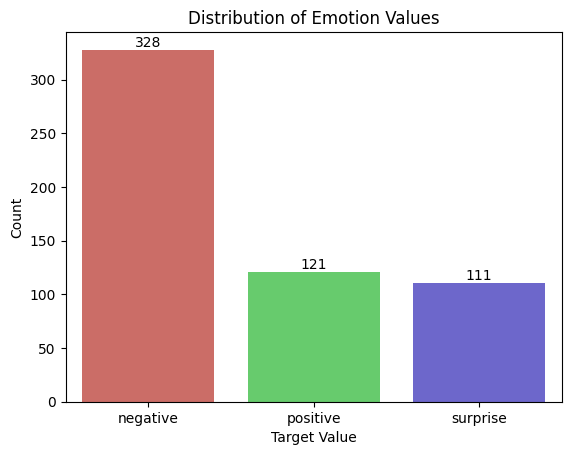

In [10]:
# Get the counts of each target value
target_value_counts = df['high_level_emotion'].value_counts()

# Create a bar plot
ax = sns.barplot(x=target_value_counts.index, y=target_value_counts.values, palette='hls',)

# Show the number of observations inside each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Distribution of Emotion Values')
plt.show()

**Observation**

It seems there are unbalanced count of negative comparing to other label

2.2 Visual Inspectation

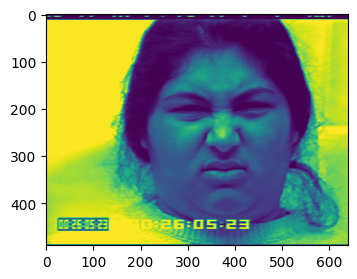

In [11]:
# For simplicity, let's just take the first subject and its first sequence
subject_sequence = df[(df['subject'] == 'S005') & (df['sequence'] == 1)]
sequence_files = subject_sequence['filepath'].tolist()

# Ensure that axes is always iterable
fig, axes = plt.subplots(1, len(sequence_files), figsize=(15, 3))
if len(sequence_files) == 1:
    axes = [axes]  # Make it a list so it's iterable

for ax, file in zip(axes, sequence_files):
    # Correct the file path by stripping the redundant part
    corrected_file_path = file.replace('./cohn-kanade-images/', '')
    img_path = os.path.join(IMAGE_DIRECTORY, corrected_file_path)
    try:
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('on')
    except IOError:
        print(f"Error opening image: {img_path}")

plt.show()

In [12]:
# Define an empty list to hold image sizes
image_sizes = []

# Define lists to hold mean and standard deviation of pixel values
mean_pixel_values = []
std_pixel_values = []

# Define a list to hold paths of corrupt images
corrupt_images = []

img_path_list = []
# Loop through the file paths in your DataFrame
for file_path in df['filepath']:
    corrected_file_path = file_path.replace('./cohn-kanade-images/', '')
    img_path = os.path.join(IMAGE_DIRECTORY, corrected_file_path)
    img_path_list.append(img_path)
    try:
        # Open the image and convert it to RGB (in case some are grayscale)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Check if the image is read correctly
        if img is not None:
            # Append the image size
            image_sizes.append(img.shape)
            
            # Calculate and store the mean and standard deviation of pixel values
            mean_pixel_values.append(np.mean(img))
            std_pixel_values.append(np.std(img))
        else:
            # If img is None, the image is corrupt
            corrupt_images.append(img_path)
            
    except Exception as e:
        # If an exception is raised, the image is likely corrupt
        corrupt_images.append(img_path)

In [13]:
# Now let's analyze the image sizes
image_sizes = np.array(image_sizes)
unique_sizes = np.unique(image_sizes, axis=0)

# We can print out or plot the unique sizes to decide on a common size
print(f"Unique image sizes: {unique_sizes}")

Unique image sizes: [[480 640   3]
 [480 720   3]
 [490 640   3]]


In [14]:
# Calculate the overall mean and standard deviation for the pixel values
overall_mean = np.mean(mean_pixel_values)
overall_std = np.std(std_pixel_values)

print(f"Overall mean pixel value: {overall_mean}")
print(f"Overall standard deviation of pixel values: {overall_std}")

# Print out corrupt images, if any
if corrupt_images:
    print("Found corrupt images:")
    for corrupt_img in corrupt_images:
        print(corrupt_img)
else:
    print("No corrupt images found.")

Overall mean pixel value: 99.93890188972647
Overall standard deviation of pixel values: 9.063075756547514
No corrupt images found.


In [15]:
# Background Consistency Check
background_modes = []

for img_path in img_path_list:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale simplifies the analysis
    border_pixels = np.concatenate([img[0, :], img[-1, :], img[:, 0], img[:, -1]])  # Extract border pixels
    mode = stats.mode(border_pixels)  # Find the mode of the border pixels
    background_modes.append(mode)

/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_72378/3067096416.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(border_pixels)  # Find the mode of the border pixels


Mean mode value: 11.378571428571428
Standard deviation of mode values: 47.69470887951871


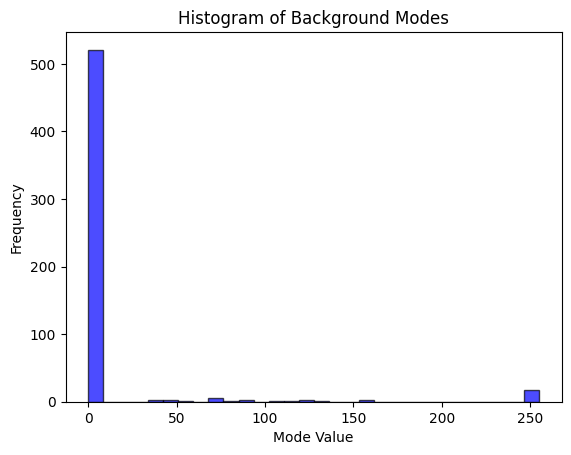

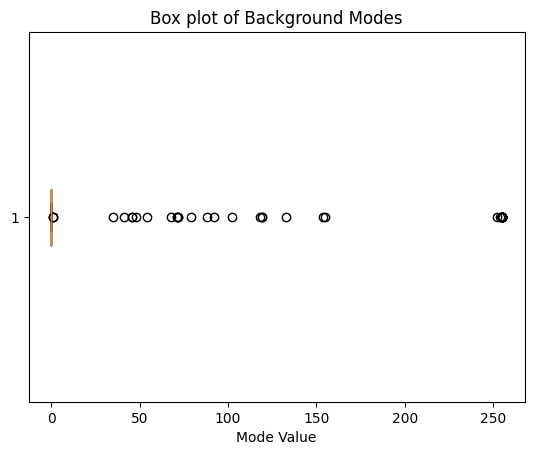

In [16]:

# Extract the mode values and counts
mode_values = [mode.mode[0] for mode in background_modes]
mode_counts = [mode.count[0] for mode in background_modes]

# Calculate basic statistics
mean_mode = np.mean(mode_values)
std_dev_mode = np.std(mode_values)

print(f"Mean mode value: {mean_mode}")
print(f"Standard deviation of mode values: {std_dev_mode}")

# Visualize the distribution of mode values
plt.hist(mode_values, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Background Modes')
plt.xlabel('Mode Value')
plt.ylabel('Frequency')
plt.show()

# Box plot for detecting outliers
plt.boxplot(mode_values, vert=False)
plt.title('Box plot of Background Modes')
plt.xlabel('Mode Value')
plt.show()

## [3] SETUP AND EXTRACT ESSENTIAL DATA 

In [17]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

class CustomDataLoader(Sequence):
    def __init__(self, image_filepaths, labels, batch_size, image_size, shuffle=True, augment=False):
        """
        Custom data loader for CNN.
    
        :param image_filepaths: List of file paths for the images.
        :param labels: Dictionary containing AU labels and emotion labels.
        :param batch_size: Batch size for the data loader.
        :param image_size: Tuple representing the size of the image.
        :param shuffle: Boolean, whether to shuffle the data after each epoch.
        :param augment: Boolean, whether to apply data augmentation.
        """
        self.image_filepaths = image_filepaths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.feature_extractor = VGG16(weights='imagenet', include_top=False)
        self.feature_extractor = Model(inputs=self.feature_extractor.inputs, outputs=self.feature_extractor.layers[-1].output)
        self.on_epoch_end()

        # Data augmentation configuration
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.datagen = ImageDataGenerator()

    def __len__(self):
        """
        Number of batches per epoch.
        """
        return int(np.ceil(len(self.image_filepaths) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        # Generate indexes of the batch
        indexes = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        """
        Updates indexes after each epoch.
        """
        self.indices = np.arange(len(self.image_filepaths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, indexes):
        """
        Generates data containing batch_size samples.
        """
        dummy_img = np.zeros((1, *self.image_size, 3))  # Assuming image_size is correctly set for VGG16 input
        dummy_feature = self.feature_extractor.predict(dummy_img)
        feature_shape = dummy_feature.shape[1:]

        # Initialization
        X = np.empty((len(indexes), *feature_shape))
        y_facs = np.empty((len(indexes), len(self.labels['facs_output'][0])), dtype=int)
        y_emotion = np.empty((len(indexes), len(self.labels['emotion_output'][0])), dtype=int)

        # Generate data
        for i, idx in enumerate(indexes):
            # Load and preprocess the image
            img = load_img(self.image_filepaths[idx], target_size=self.image_size)
            img = img_to_array(img)
            # img = self.datagen.standardize(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)

            # Extract features
            features = self.feature_extractor.predict(img)

            # Store features
            X[i,] = features[0]

            # Store class
            y_facs[i] = self.labels['facs_output'][idx]
            y_emotion[i] = self.labels['emotion_output'][idx]

        return X, {'facs_output': y_facs, 'emotion_output': y_emotion}

# Correct and set up proper file path
image_filepaths = df['filepath'].tolist()
n_image_filepaths = []
for path in image_filepaths:
    a = path[:2] + "data-1/" + path[2:]
    n_image_filepaths.append(a)

# Set up label 
labels = {
    'facs_output': df.iloc[:, 5:20].values,
    'emotion_output': to_categorical(df['high_level_emotion_num'].tolist(), num_classes = 3)
}


In [18]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Split the data into training and validation sets
X_train_paths, X_temp_paths, _, _ = train_test_split(n_image_filepaths, n_image_filepaths, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_val_paths, X_test_paths, _, _ = train_test_split(X_temp_paths, X_temp_paths, test_size=0.5, random_state=RANDOM_STATE)

# facs_output labels
y_train_facs, y_temp_facs, _, _ = train_test_split(labels['facs_output'], labels['facs_output'], test_size=TEST_SIZE, random_state=RANDOM_STATE)
y_val_facs, y_test_facs, _, _ = train_test_split(y_temp_facs, y_temp_facs, test_size=0.5, random_state=RANDOM_STATE)

# emotion_output labels
y_train_emotion, y_temp_emotion, _, _ = train_test_split(labels['emotion_output'], labels['emotion_output'], test_size=TEST_SIZE, random_state=RANDOM_STATE)
y_val_emotion, y_test_emotion, _, _ = train_test_split(y_temp_emotion, y_temp_emotion, test_size=0.5, random_state=RANDOM_STATE)


# Create loader for train, val , test
train_loader = CustomDataLoader(X_train_paths, {'facs_output': y_train_facs, 'emotion_output': y_train_emotion}, batch_size=32, image_size=(224, 224), shuffle=True, augment=True)
val_loader = CustomDataLoader(X_val_paths, {'facs_output': y_val_facs, 'emotion_output': y_val_emotion}, batch_size=32, image_size=(224, 224), shuffle=False, augment=False)
test_loader = CustomDataLoader(X_test_paths, {'facs_output': y_test_facs, 'emotion_output': y_test_emotion}, batch_size=32, image_size=(224, 224), shuffle=False, augment=False)

2023-11-21 17:16:35.387114: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-11-21 17:16:35.387135: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-21 17:16:35.387138: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-21 17:16:35.387170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-21 17:16:35.387185: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## [4] MODEL TRAINING

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D

4.1 Design Model Structure

In [20]:
# input_layer = Input(shape=(48, 48, 1)) # INPUT WILL BE IMAGE WITH DESIGNED DIMENSIONS
# # Example CNN layers
# x = Conv2D(32, (3, 3), activation='relu')(input_layer)
# # x = BatchNormalization()(x)  # Adding batch normalization
# x = MaxPooling2D((2, 2))(x)
# # x = Dropout(0.5)(x)  # Adding dropout
# x = Flatten()(x)

# # FACS codes output
# facs_output = Dense(15, activation='sigmoid', name='facs_output')(x) # 15 FACS codes

# # Emotion label output
# emotion_output = Dense(3, activation='softmax', name='emotion_output')(x) # 3 emotion labels

# # Create the model
# model = Model(inputs=input_layer, outputs=[facs_output, emotion_output])

# model.compile(optimizer='adam', 
#               loss={'facs_output': 'binary_crossentropy', 'emotion_output': 'categorical_crossentropy'}, 
#               metrics=['accuracy'])

In [21]:
input_layer = Input(shape=(7, 7, 512)) # INPUT WILL BE IMAGE WITH DESIGNED DIMENSIONS

# input_layer = Input(shape=(224, 224, 1)) # INPUT WILL BE IMAGE WITH DESIGNED DIMENSIONS

# # Adding more CNN layers
# x = Conv2D(32, (3, 3), activation='relu')(input_layer)
# x = Conv2D(64, (3, 3), activation='relu')(x)
# x = MaxPooling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation='relu')(x)
# x = Conv2D(256, (3, 3), activation='relu')(x)  # New Conv layer
# x = MaxPooling2D((2, 2))(x)
# x = Conv2D(512, (3, 3), activation='relu')(x)  # New Conv layer
# x = MaxPooling2D((2, 2))(x)

# Adjusted network
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# Global Pooling instead of Flattening and MaxPooling
x = GlobalAveragePooling2D()(x)

# Adding batch normalization and dropout for regularization
x = BatchNormalization()(x)
x = Dropout(0.5)(x)


# FACS Branch
facs_branch = Flatten()(x)
facs_branch = Dense(128, activation='relu')(facs_branch)
facs_branch = Dropout(0.5)(facs_branch)
facs_output = Dense(15, activation='sigmoid', name='facs_output')(facs_branch)

# Emotion Branch
emotion_branch = Flatten()(x)
emotion_branch = Dense(64, activation='relu')(emotion_branch)
emotion_branch = Dropout(0.5)(emotion_branch)
emotion_output = Dense(3, activation='softmax', name='emotion_output')(emotion_branch)

# Create the model
model = Model(inputs=input_layer, outputs=[facs_output, emotion_output])

model.compile(optimizer='adam', 
              loss={'facs_output': 'binary_crossentropy', 'emotion_output': 'categorical_crossentropy'}, 
              metrics=['accuracy'])

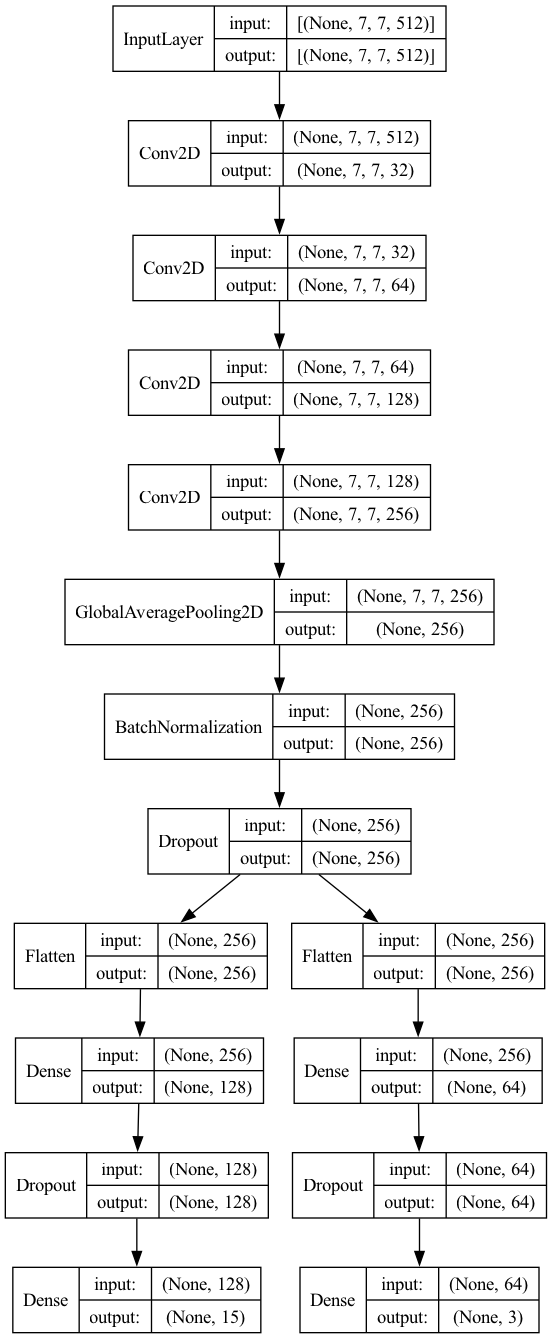

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names=False, show_shapes=True, to_file='model.png')

In [23]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 7, 7, 512)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 7, 7, 32)             147488    ['input_4[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 7, 7, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [24]:
# Change in training configuration
epochs = 128
batch_size = 32

# # Training the model with the updated configuration
# history = model.fit(X_train, {'facs_output': y_train_facs, 'emotion_output': y_train_emotion}, 
#                     validation_data=(X_val, {'facs_output': y_val_facs, 'emotion_output': y_val_emotion}), 
#                     epochs=epochs, batch_size=batch_size)


history = model.fit(train_loader, 
                    validation_data=val_loader,
                    epochs=35)

2023-11-21 17:16:39.467819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step
Epoch 1/35
1/1 [==============================] - 0s 13ms/step


2023-11-21 17:16:42.897923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 3.0255 - facs_output_loss: 1.1084 - emotion_output_loss: 1.9171 - facs_output_accuracy: 0.0938 - emotion_output_accuracy: 0.4754

2023-11-21 17:17:13.683547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


2023-11-21 17:17:15.864712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 39s 2s/step - loss: 3.0255 - facs_output_loss: 1.1084 - emotion_output_loss: 1.9171 - facs_output_accuracy: 0.0938 - emotion_output_accuracy: 0.4754 - val_loss: 13.3703 - val_facs_output_loss: 3.5137 - val_emotion_output_loss: 9.8566 - val_facs_output_accuracy: 0.2143 - val_emotion_output_accuracy: 0.1786
Epoch 2/35
14/14 [==============================] - 23s 2s/step - loss: 2.1566 - facs_output_loss: 0.9066 - emotion_output_loss: 1.2500 - facs_output_accuracy: 0.0915 - emotion_output_accuracy: 0.5893 - val_loss: 10.3635 - val_facs_output_loss: 3.7089 - val_emotion_output_loss: 6.6546 - val_facs_output_accuracy: 0.0000e+00 - val_emotion_output_accuracy: 0.2857
Epoch 3/35
14/14 [==============================] - 23s 2s/step - loss: 1.8145 - facs_output_loss: 0.8470 - emotion_output_loss: 0.9675 - facs_output_accuracy: 0.1250 - emotion_output_accuracy: 0.6451 - val_loss: 8.8883 - val_facs_output_loss: 3.1462 - val_emotion_output_loss: 5.7421 - va

In [25]:
# Evaluate the model on the test set
evaluation = model.evaluate(test_loader)

# Unpacking the evaluation results
total_loss = evaluation[0] # Total loss
loss_facs = evaluation[1] # Loss for FACS output
loss_emotion = evaluation[2] # Loss for emotion output
accuracy_facs = evaluation[3] # Accuracy for FACS output
accuracy_emotion = evaluation[4] # Accuracy for emotion output

2023-11-21 17:30:41.762829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 1s/step - loss: 2.5079 - facs_output_loss: 0.5770 - emotion_output_loss: 1.9308 - facs_output_accuracy: 0.3571 - emotion_output_accuracy: 0.6786


In [26]:
predictions = model.predict(test_loader)

1/1 [==============================] - 0s 12ms/step


2023-11-21 17:30:47.991280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 1s/step


In [27]:
facs_predictions, emotion_predictions = predictions
# Processing FACS predictions: Convert probabilities to binary values
facs_pred_binary = (facs_predictions > 0.5).astype(int)

# Processing Emotion predictions: Convert probabilities to class labels
emotion_pred_labels = np.argmax(emotion_predictions, axis=1)

In [28]:
len(facs_pred_binary)

56

In [29]:
facs_pred_binary

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0,

In [30]:
len(emotion_pred_labels)

56

In [31]:
emotion_pred_labels

array([0, 2, 0, 2, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 2, 2, 1, 0,
       0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 1, 2, 0, 1, 2, 0, 0, 0, 1, 1, 0,
       0, 1, 2, 0, 0, 1, 2, 2, 0, 1, 1, 2])

In [32]:
names = ['negative','positive','surprise']

def getLabel(id):
    return ['negative','positive','surprise'][id]

In [33]:
# Tune note
    # Optimizer (Learning Rate, etc...)
    # Image Augumentation
    # Adjust Epoch
